# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [2]:
# Import stuff.
import matplotlib as mp
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from ast import literal_eval



# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [3]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [4]:
# Show the list of column names and the number of rules.

print(df_rules.columns)
print(len(df_rules))

Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object')
1048575


In [5]:
df_rules.head(-5)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
...,...,...,...,...,...,...
1048565,Breaded Chicken Dunks Lunchables,3346083,190,3346083,190,[]
1048566,Blueberry Mini Bagels,3346083,190,3346083,190,[]
1048567,Bibimbop With Beef & Brown Rice,3346083,190,3346083,190,[]
1048568,Asiago Pressato,3346083,190,3346083,190,[]


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [6]:
def support(df_rules):
    return df_rules['item_set_count']/df_rules['transaction_count']
def confidence(df_rules):
    return df_rules['item_set_count']/df_rules['antecedent_count']
def lift(df_rules):
    return ((df_rules['item_set_count']*df_rules['transaction_count'])/(df_rules['antecedent_count']*df_rules['consequent_count']))
df_rules['support'] = support(df_rules)
df_rules['confidence'] = confidence(df_rules)
df_rules['lift'] = lift(df_rules)
df_rules


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
...,...,...,...,...,...,...,...,...,...
1048570,Apples and Plums Stage 2 Baby Food,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048571,Apitherapy Raw Honey,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048572,Antioxidant Super Tea Pomegranate Peach Passio...,3346083,190,3346083,190,[],0.000057,0.000057,1.000000
1048573,All Natural Sausage Fully Cooked - 6 CT,3346083,190,3346083,190,[],0.000057,0.000057,1.000000


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

In [7]:

# This is because the actual odds of buying any particular yogurt is low(support), but the odds of buying a yogurt given the fact that 
# I bought a different yogurt is extremely high (confidence).
#There are a ton of yogurts in this data set thus all of their confidence would be higher than average. Dividing the higher confidence by its low support results in an insanely high number 


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [8]:
# Define df_rules_subset.
condition_1 = df_rules['antecedent_items'].apply(lambda x: len(x)==1)
condition_2 = (df_rules['lift'] >=5) & (df_rules['lift']<=20)
df_rules_subset = df_rules[condition_1&condition_2]
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])
df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(
    lambda x: 'Hummus' if 'Hummus' in x else x
)
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].apply(
    lambda x: 'Hummus' if 'Hummus' in x else x
)
condition_3 = df_rules_subset['antecedent_items'].apply(lambda x: x=='Hummus')
condition_4 = df_rules_subset['consequent_item'].apply(lambda x: x != 'Hummus')
condition_5 = df_rules_subset['antecedent_items'].apply(lambda x: x!='Hummus')
condition_6 = df_rules_subset['consequent_item'].apply(lambda x: x=='Hummus')
df_rules_subset = df_rules_subset[condition_3 & condition_4 | condition_5&condition_6]
len(df_rules_subset)

/var/folders/0j/6cz1795512zg1r1xwfzvsn340000gn/T/ipykernel_64889/1698960514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(lambda x: x[0])
/var/folders/0j/6cz1795512zg1r1xwfzvsn340000gn/T/ipykernel_64889/1698960514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(
/var/folders/0j/6cz1795512zg1r1xwfzvsn340000gn/T/ipykernel_64889/1698960514.py:

25

Build a network `graph_rules_subset` from the association rules subset.

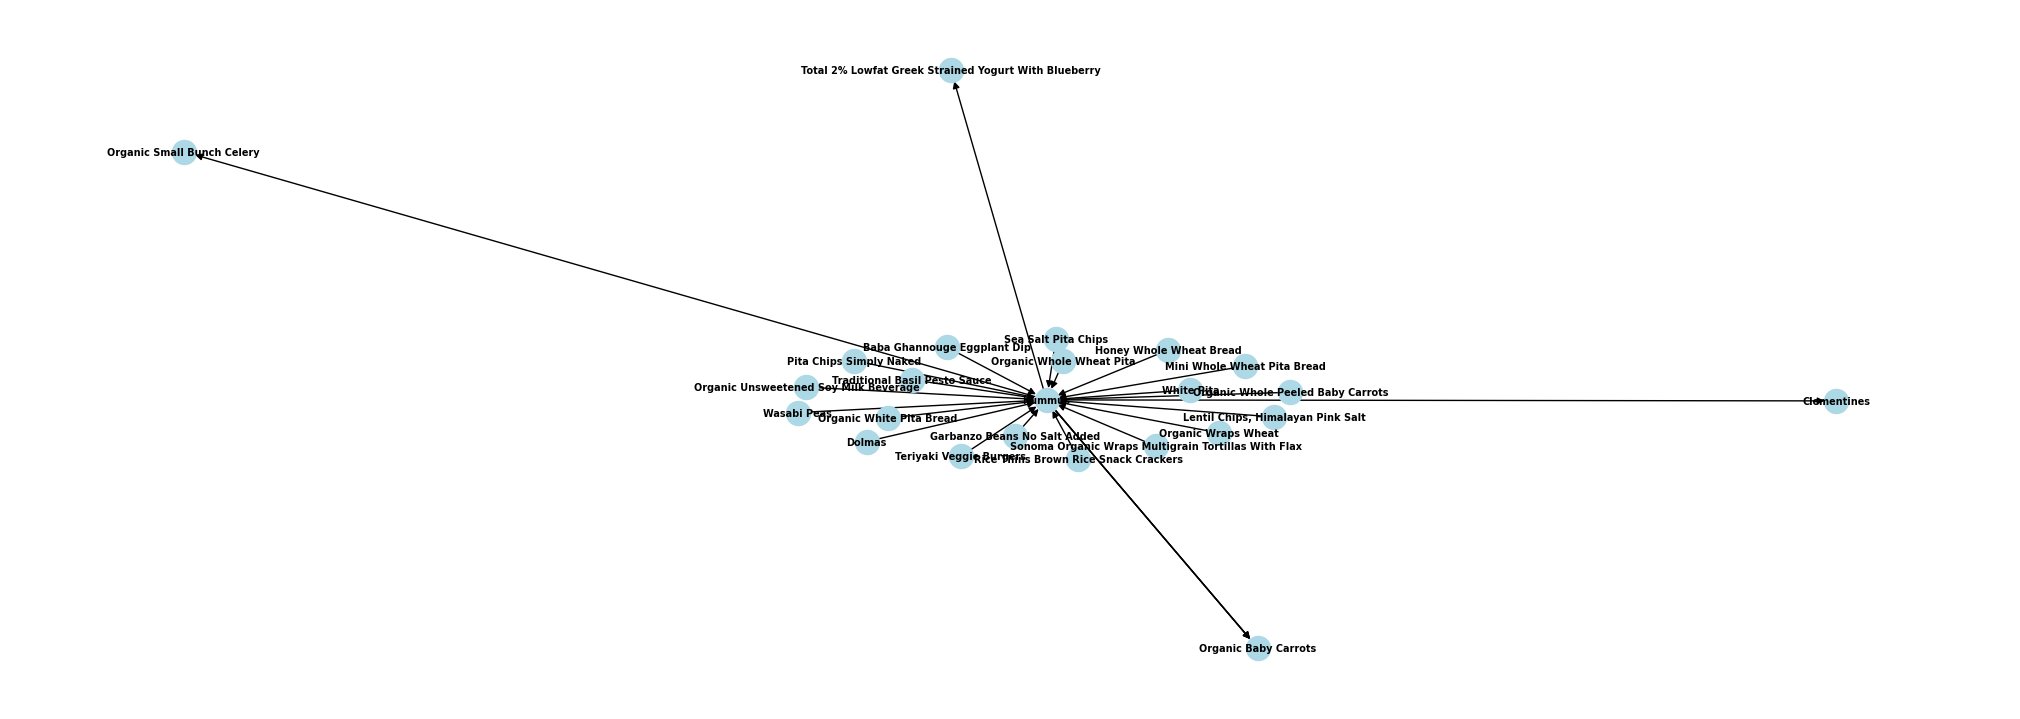

In [9]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()
plt.figure(figsize=(20, 7))
graph_rules_subset.add_edges_from(
    zip(df_rules_subset['antecedent_items'],df_rules_subset['consequent_item'])
)
nx.draw(graph_rules_subset, with_labels=True, node_color='lightblue', font_weight='bold',font_size = 7)
plt.show()



What can you tell about people who buy hummus?

*(Write your answer here.)*
#they are likely to buy celery and baby carrots afterwards. also buying Hummus is a consequence for many items

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [13]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}
df_rules[df_rules['antecedent_items'].apply(basket.issuperset)
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
364989,Organic Bell Pepper,3346083,582,2721,24331,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000174,0.213892,29.415159
370144,Yellow Bell Pepper,3346083,499,2721,26625,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000149,0.183388,23.047249
370169,Yellow Bell Pepper,3346083,7520,41052,26625,[Orange Bell Pepper],0.002247,0.183182,23.021341
386994,Organic Bell Pepper,3346083,6024,59878,24331,[Organic Red Bell Pepper],0.001800,0.100605,13.835486
404185,Green Bell Pepper,3346083,494,2721,58005,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000148,0.181551,10.472966
449846,Red Peppers,3346083,5529,41052,58185,[Orange Bell Pepper],0.001652,0.134683,7.745295
480595,Green Bell Pepper,3346083,7086,59878,58005,[Organic Red Bell Pepper],0.002118,0.118341,6.826611
531201,Green Bell Pepper,3346083,4144,41052,58005,[Orange Bell Pepper],0.001238,0.100945,5.823133
603392,Organic Red Onion,3346083,278,2721,70804,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000083,0.102168,4.828310
657541,Organic Cucumber,3346083,6480,59878,85005,[Organic Red Bell Pepper],0.001937,0.108220,4.259905


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.